In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'numpy', 'pandas', 'matplotlib', 'scipy', 'torch', '-q'])

0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.stats import gaussian_kde
import os

os.makedirs('outputs', exist_ok=True)

In [3]:
df = pd.read_csv('data/india_air_quality_data.csv', encoding='latin-1')
x = df['no2'].dropna().values.astype(np.float32)
print(f'samples: {len(x)},  min: {x.min():.2f},  max: {x.max():.2f}')

samples: 419509,  min: 0.00,  max: 876.00


/var/folders/xy/yvrq73bs11v027l8jl7mp6tw0000gn/T/ipykernel_93817/2729979621.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/india_air_quality_data.csv', encoding='latin-1')


In [4]:
r = 102303230
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)
print(f'a_r = {a_r},  b_r = {b_r}')

z = x + a_r * np.sin(b_r * x)
print(f'z  mean = {z.mean():.4f},  std = {z.std():.4f}')

a_r = 0.5,  b_r = 0.3
z  mean = 25.7925,  std = 18.5091


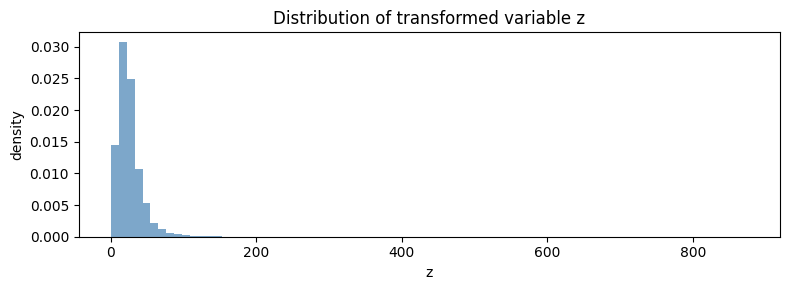

In [5]:
plt.figure(figsize=(8, 3))
plt.hist(z, bins=80, density=True, color='steelblue', alpha=0.7)
plt.title('Distribution of transformed variable z')
plt.xlabel('z')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('outputs/z_distribution.png', dpi=150)
plt.show()

In [6]:
z_clipped = z[z < np.percentile(z, 99)]
z_clipped = z_clipped[z_clipped > 0]

z_log = np.log(z_clipped)
z_mean = z_log.mean()
z_std  = z_log.std()
z_norm = (z_log - z_mean) / z_std
z_tensor = torch.tensor(z_norm.astype(np.float32)).unsqueeze(1)
print(f'log-transformed  mean={z_log.mean():.4f}  std={z_log.std():.4f}')

log-transformed  mean=3.0338  std=0.6157


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator()
D = Discriminator()
print(G)
print(D)

Generator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
opt_g = torch.optim.Adam(G.parameters(), lr=5e-4)
opt_d = torch.optim.Adam(D.parameters(), lr=5e-4)
criterion = nn.BCELoss()

epochs     = 3000
batch_size = 256
n          = len(z_tensor)
d_losses   = []
g_losses   = []

for epoch in range(epochs):
    idx          = torch.randint(0, n, (batch_size,))
    real         = z_tensor[idx]
    noise        = torch.randn(batch_size, 1)
    fake         = G(noise).detach()
    real_labels  = torch.ones(batch_size, 1)
    fake_labels  = torch.zeros(batch_size, 1)

    d_loss = criterion(D(real), real_labels) + criterion(D(fake), fake_labels)
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    noise  = torch.randn(batch_size, 1)
    g_loss = criterion(D(G(noise)), real_labels)
    opt_g.zero_grad()
    g_loss.backward()
    opt_g.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'epoch {epoch+1:4d}  d_loss={d_loss.item():.4f}  g_loss={g_loss.item():.4f}')

epoch  500  d_loss=1.5545  g_loss=0.5813
epoch 1000  d_loss=1.0997  g_loss=0.9482
epoch 1500  d_loss=1.3709  g_loss=0.6812
epoch 2000  d_loss=1.3730  g_loss=0.6912
epoch 2500  d_loss=1.3846  g_loss=0.6714
epoch 3000  d_loss=1.4045  g_loss=0.6774


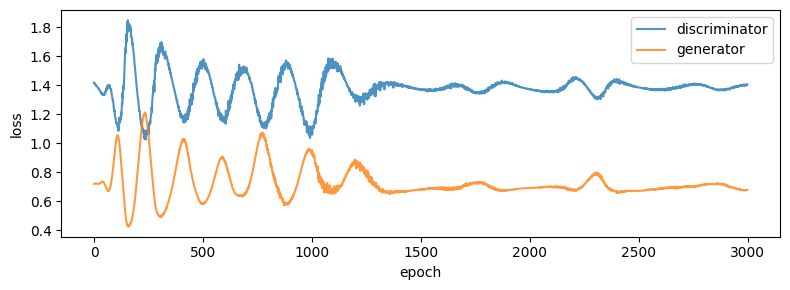

In [9]:
plt.figure(figsize=(8, 3))
plt.plot(d_losses, label='discriminator', alpha=0.8)
plt.plot(g_losses, label='generator', alpha=0.8)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/training_loss.png', dpi=150)
plt.show()

In [10]:
with torch.no_grad():
    noise       = torch.randn(10000, 1)
    z_fake      = G(noise).numpy().flatten()

z_fake_log  = z_fake * z_std + z_mean
z_fake_orig = np.exp(z_fake_log)
print(f'generated  mean={z_fake_orig.mean():.4f}  std={z_fake_orig.std():.4f}')

generated  mean=22.3149  std=7.6818


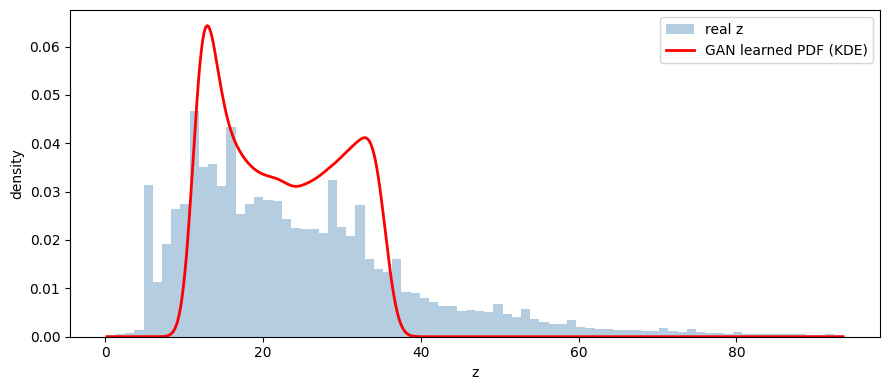

In [11]:
kde     = gaussian_kde(z_fake_orig)
x_range = np.linspace(z_clipped.min(), z_clipped.max(), 500)

plt.figure(figsize=(9, 4))
plt.hist(z_clipped, bins=80, density=True, alpha=0.4, color='steelblue', label='real z')
plt.plot(x_range, kde(x_range), 'r-', lw=2, label='GAN learned PDF (KDE)')
plt.xlabel('z')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/gan_pdf.png', dpi=150)
plt.show()

In [14]:
print(f'Roll number : 102303230')
print(f'a_r         : {a_r}')
print(f'b_r         : {b_r}')
print()
print('Generator   : Linear(1,32) -> Tanh -> Linear(32,32) -> Tanh -> Linear(32,1)')
print('Discriminator: Linear(1,32) -> LeakyReLU -> Linear(32,32) -> LeakyReLU -> Linear(32,1) -> Sigmoid')
print()
print('PDF estimated using KDE on 10000 generator samples')
print('Output plots saved in outputs/')

Roll number : 102303230
a_r         : 0.5
b_r         : 0.3

Generator   : Linear(1,32) -> Tanh -> Linear(32,32) -> Tanh -> Linear(32,1)
Discriminator: Linear(1,32) -> LeakyReLU -> Linear(32,32) -> LeakyReLU -> Linear(32,1) -> Sigmoid

PDF estimated using KDE on 10000 generator samples
Output plots saved in outputs/
